In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel

import datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
from PIL import Image

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
class BinomialScheduler:
    def __init__(self, TrainSteps):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'

        self.betas = torch.linspace(0.0001, 0.015, TrainSteps, device=self.noiseDevice)

        #self.betas = torch.linspace(0.0001, 0.25, 5, device=self.noiseDevice) #TEST WITH trainstesp = 5
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
         # The last value of alpha_cumprod should be close to 0.5

    def addNoise(self, imageBatch, time):
        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # Compute the flip probability (beta_t = 1 - alpha_t)
            beta_t = 1 - alpha_t
            probabilities = beta_t.expand_as(imageBatch)

            # Generate a binary noise mask with probability beta_t
            noise_mask = torch.bernoulli(probabilities).to(imageBatch.device)

            # Flip the bits in the image using the noise mask (XOR operation)
            noisedImages = imageBatch * (1 - noise_mask) + (1 - imageBatch) * noise_mask
            return noisedImages, noise_mask
        
    def denoise(self, x_t, predictedMask, time):
        with torch.no_grad():
            x_0 = x_t * (1 - predictedMask) + (1 - x_t) * predictedMask
            x_t_minus_1, _ = self.addNoise(x_0, (time-1).to(self.noiseDevice))
            return x_t_minus_1            

In [ ]:
scheduler = BinomialScheduler(100)

mnist_dataset = datasets.load_dataset('mnist', split='train')

class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']

        # Convert PIL image to NumPy array
        if isinstance(image, Image.Image):  
            image = np.array(image)  # Convert to NumPy

        # Convert NumPy array to PyTorch tensor and normalize
        image = (torch.tensor(image, dtype=torch.float32) / 255.0).round()  # Normalize to [0,1]
        image = image.unsqueeze(0)  # Add channel dimension -> [1, 28, 28]
        
        # Convert label to a tensor
        label = torch.tensor(item['label'], dtype=torch.long)
        
        return image, label

# Wrap the dataset
pytorch_dataset = MNISTDataset(mnist_dataset)

trainDataloader = DataLoader(pytorch_dataset, batch_size=128, shuffle=True)

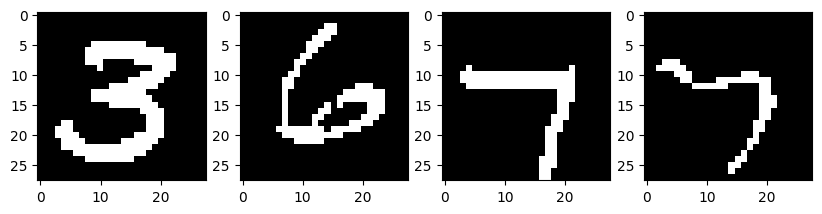

In [39]:
# Show example images, to make sure it works 
smallBatch = next(iter(trainDataloader))[0][0:4] # shape (4, 1, 28, 28)

fig, axes = plt.subplots(1, 4, figsize=(10, 3))

for i, image in enumerate(smallBatch):
    axes[i].imshow(image[0], cmap='gray')
plt.show()

# Some of these digits don't look right, perhaps a lower threshold for binarization would be better.
# This might make results unclear, as even when correct, one might not recognize the digits correctly.

100%|██████████| 5/5 [00:00<00:00, 5018.31it/s]


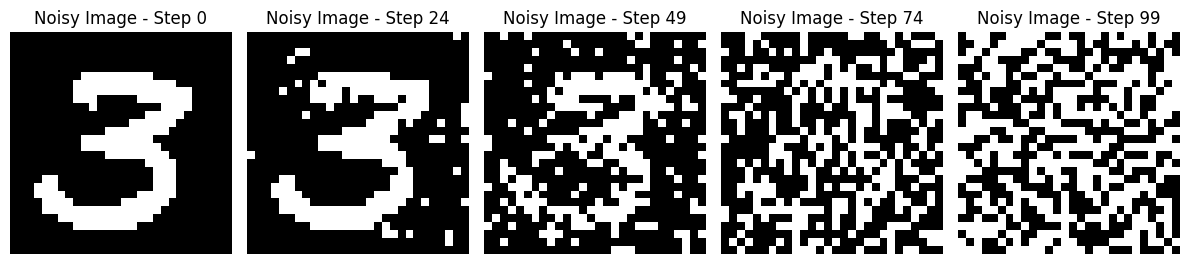

In [40]:
# Visualize to make sure binomial noise is working correctly

pureImage = smallBatch[0:1]#.float()
num_samples = 5
inferenceSteps = torch.linspace(0, scheduler.TrainSteps-1, num_samples)
noisy_images = []
noises = []

for t in tqdm(inferenceSteps):
    noisyImage, noise = scheduler.addNoise(pureImage, t.long())
    noisy_images.append(noisyImage)
    noises.append(noise)

fig, axes = plt.subplots(1, num_samples , figsize=(12, 4))

# Display each noisy image
for i, noisyImage in enumerate(noisy_images):
    axes[i].imshow(noisyImage.detach().cpu().numpy().squeeze(), cmap='gray')
    axes[i].set_title(f'Noisy Image - Step {int(inferenceSteps[i])}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

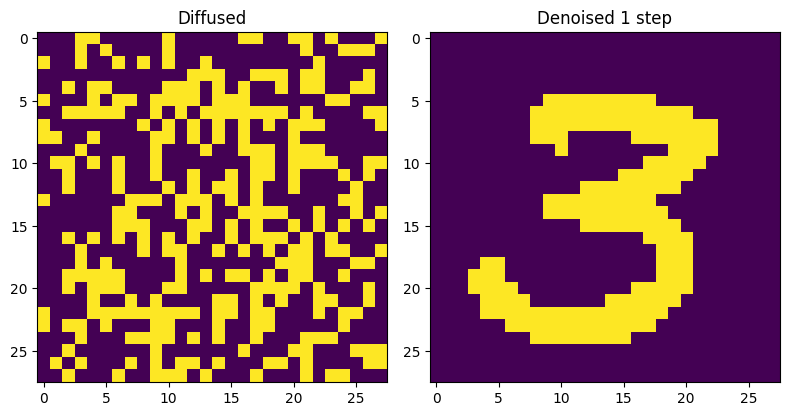

In [49]:
#Denoise 1 step

t = 3
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(noisy_images[t][0,0])
axes[0].set_title("Diffused")

predictedNoise = noises[t]
x_t = noisy_images[t]
x_t_minus_1 = scheduler.denoise(x_t, predictedNoise, torch.tensor(t))

axes[1].imshow(x_t_minus_1[0,0])
axes[1].set_title("Denoised 1 step")

plt.tight_layout()
plt.show()

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

model = UNet2DModel(
    sample_size=28,   # image resolution
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 64, 64),
    down_block_types=( 
        "DownBlock2D",    
        "DownBlock2D",   
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "UpBlock2D",   
        "UpBlock2D",        
    ),
).to(device)

Using device: cuda


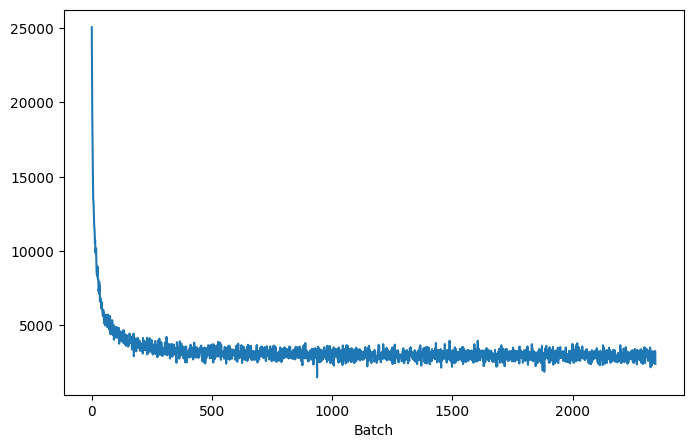

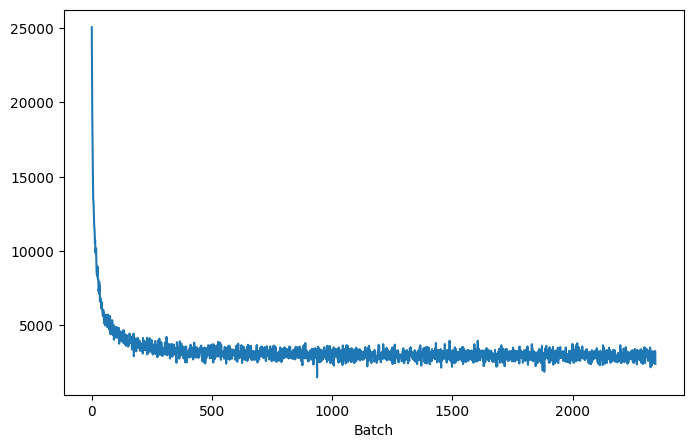

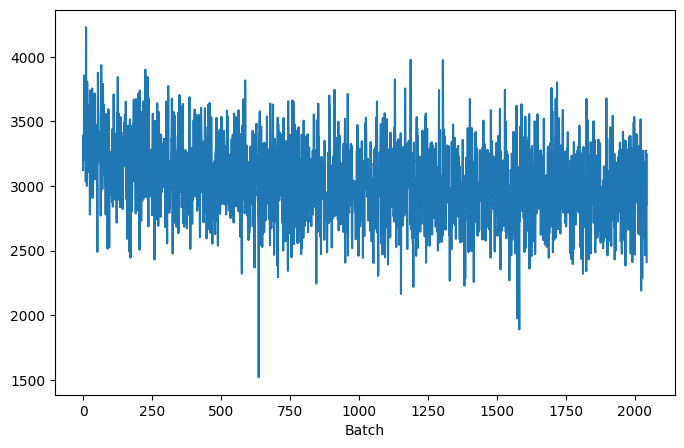

In [108]:
PLOTUPDATES = True
updateRate = 1
n_epochs = 5

opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

loss_fn = nn.MSELoss(reduction='sum')
losses = []

if PLOTUPDATES:
    fig, ax = plt.subplots(figsize=(8, 5))

for epoch in range(n_epochs):
    opt.zero_grad()

    for batch in tqdm(trainDataloader):
        batch = batch[0] #Image is a list 

        timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

        noisyImg, noiseMask = scheduler.addNoise(batch, timesteps)

        pred = model(noisyImg.to(device), timesteps.to(device)).sample
        pred = F.sigmoid(pred) # Do i round the values?

        loss = loss_fn(pred, noiseMask.to(device)) 

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if PLOTUPDATES:
        if epoch % updateRate == 0:
            clear_output(wait=True)  
            ax.clear()
            plt.plot(losses)
            plt.xlabel('Batch')
            display(fig)
            
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(losses[300:])
plt.xlabel('Batch')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 133.92it/s]


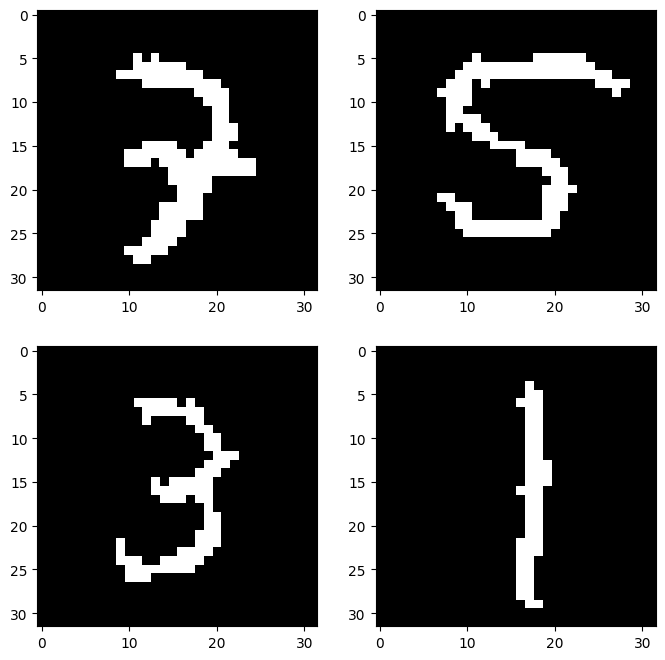

In [113]:
#Inference # I think the issue is that is is trying to remove all the noise in a single step

x = torch.randint(0, 2, (4, 1, 32, 32), device=device).float()
inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps, device=device)

for t in tqdm(inferenceSteps):
    t = t.long()
    with torch.no_grad():
        pred = torch.sigmoid(model(x, t).sample).round()
    x = scheduler.denoise(x, pred, t)

# argmax_images = torch.argmax(x, dim=1, keepdim=True)
# Show the results
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(x[0,0].cpu(), cmap='gray')
axs[0, 1].imshow(x[1,0].cpu(), cmap='gray')
axs[1, 0].imshow(x[2,0].cpu(), cmap='gray')
axs[1, 1].imshow(x[3,0].cpu(), cmap='gray')


plt.show()

100%|██████████| 100/100 [00:01<00:00, 97.23it/s] 


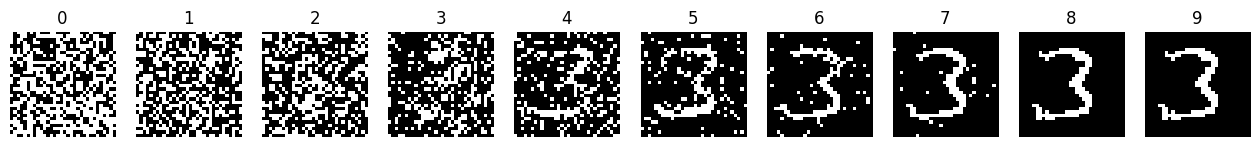

In [118]:
#Inference # I think the issue is that it is trying to remove all the noise in a single step

stepsShown = 8  # Number of steps to show in the plot
x = torch.randint(0, 2, (1, 1, 32, 32), device=device).float()
inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps, device=device)  # Change to 4 steps for 4 images
xSteps = []

for i, t in enumerate(tqdm(inferenceSteps)):
    t = t.long()
    with torch.no_grad():
        pred = torch.sigmoid(model(x, t).sample).round()
    x = scheduler.denoise(x, pred, t)

    if i % (scheduler.TrainSteps / stepsShown).__floor__() == 0:
        # Show the results for one sample across different steps
        xSteps.append(x.clone())

xSteps.append(x.clone())
    
    

fig, axs = plt.subplots(1, stepsShown + 2, figsize=(16, 4))  # Adjust subplot configuration for 1 row, 4 columns
for i, img in enumerate(xSteps):
    axs[i].imshow(img[0,0].cpu().numpy(), cmap='gray')  # Convert tensor to numpy array for imshow
    axs[i].set_title(f'{i}')
    axs[i].axis('off')
plt.show()


________